# Ejercicio Integrador DISW 2021
## EQUIPO 4:

    1. Iván Schneider (FW)
    2. Javier Bressan (FSW)
    3. Fabricio Loor (ConfigSar/DSS)
    4. Melany Hayward (Backend)

## Módulo de adquisición de datos
### introducción
El modulo adquisidor de datos es un equipo que adquiere los datos de temperatura mediante una entrada analogica conectada a un sensor LM35, se conecta por wifi a un broker mqtt y los reporta con un timestamp y un id

![image](img/i2.jpeg)

### Tarea de Recolección de datos:
<img src="img/c1.png" width="300" higth="500">


In [ ]:
void readTemp(void *pvParameter)
{
	time_t now;
	struct tm timeinfo;
	data_t data;
	uint32_t samples = 0;
	uint32_t average = 0;

	// Init ADC 1
	initialize_adc_1();

	QDatos = xQueueCreate(10,sizeof(data_t));

	while (true)
	{
		samples=0;
		for(int i=0; i<SAMPLES_QUANTITY;i++)
		{
			samples +=  adc1_get_raw(ADC_CHANNEL);
			vTaskDelay(10 / portTICK_PERIOD_MS);
		}

		// get the samples average value
		average = samples / SAMPLES_QUANTITY;
	    data.id = 123;
	    data.temp = esp_adc_cal_raw_to_voltage(average, &adc_chars);
	    // get actual time to generate the timestamp
	    time(&now);
	    localtime_r(&now, &timeinfo);
	    data.timeStamp = timeinfo;
	    // send data to the queue
		xQueueSendToFront(QDatos,&data,100/portTICK_RATE_MS);
		printf("valor adc %.1f\n",(float)data.temp/10);
	}
}

### Tarea de reporte de datos:
<img src="img/Df2.png" width="300" higth="500">

In [ ]:
case SEND_DATA_CONNECT:
    report_initConnections();
    sendDataStates = SEND_DATA_TIME;
    break;

In [ ]:
case SEND_DATA_TIME:
    if (report_got_ip())
    {
        time_t now;
        struct tm timeinfo;
        time(&now);
        localtime_r(&now, &timeinfo);
        // Is time set? If not, tm_year will be (1970 - 1900).
        while (timeinfo.tm_year < (2016 - 1900))
        {
            ESP_LOGI(TAG, "Time is not set yet. Getting time over NTP.");
            obtain_time();
            time(&now);
                    localtime_r(&now, &timeinfo);
        }
        sendDataStates = SEND_DATA_MQTT;
    }
    else
    {
        report_deinitConnections();
        sendDataStates = SEND_DATA_CONNECT;
    }
    break;

In [ ]:
case SEND_DATA_MQTT:
    if (report_got_ip())
    {
        mqtt_app_start();
        sendDataStates = SEND_DATA_PUBLISH;
    }
    else
    {
        report_deinitConnections();
        sendDataStates = SEND_DATA_CONNECT;
    }
    break;

In [ ]:

case SEND_DATA_PUBLISH:
    if (xQueuePeek(QDatos, &dato, portMAX_DELAY))
    {
        if (pdTRUE == xSemaphoreTake(s_semph_get_mqtt_broker, (10000/portTICK_PERIOD_MS)))
        {
            xSemaphoreGive(s_semph_get_mqtt_broker);
            char buffer[150];
            char topic[20];
            uint8_t length = 0;
            sprintf(topic, "sensores/nodo_%u",dato.id);
            //strftime(strftime_buf, sizeof(strftime_buf), "%c", &(dato.timeStamp.));
            length = sprintf(buffer,"{\"Id\": %u,\"temp\": %.1f, \"timestamp\": \"%u/%u/%u %u:%u:%u \"}",dato.id, (float)dato.temp/10, TM_TO_DAY(dato.timeStamp), TM_TO_MONTH(dato.timeStamp), TM_TO_YEAR(dato.timeStamp),TM_TO_HOUR(dato.timeStamp),TM_TO_MINUTE(dato.timeStamp),TM_TO_SECOND(dato.timeStamp));
            printf("enviando %s %s\n",topic ,buffer);
            if (!mqtt_publish(topic, buffer, length))// si se pudo enviar saco el dato de la cola
            {
                printf("se envio el dato\n");
                xQueueReceive(QDatos, &dato,0);
            }
        }
        else
        {
            mqtt_app_end();
            report_deinitConnections();
            sendDataStates = SEND_DATA_CONNECT;
        }
    }
    break;


## Mejoras en el End-point
Algunas de las mejoras que pensamos fueron:

- agregar un menú de configuración por uart para poder cambiar la configuración de:
    - wifi
    - mqtt
    - tiempo de reporte
- En el código agregamos una capa de abstracción entre el wifi y mqtt para poder implementar el socket tcp sobre otra capa física, por ejemplo ethernet, pero no implementamos las otras capas físicas.

- Nos falto agregar un semáforo para notificar a la tarea de readTemp para que no capture datos con un timestamp erróneo.

### Modulo de procesamiento y visualizacion de los datos
![image](img/i1.jpeg)

### Adquiriendo los datos desde el server mqtt (adquirir.py)

In [ ]:
from procesamiento.Recolector import *
from procesamiento.Procesador import *

In [ ]:
broker = Recolector_MQTT("181.47.10.131", 1883,"Guardar2.csv")
broker.subscribe("sensores/#")
broker.connect()
conectado = "connected"
proc = Procesador()
conectado = input()
while (conectado != "disconnect"):
    conectado = input()

In [ ]:
broker.disconnect()



### Procesando los datos desde el archivo con las mediciones (procesar.py)

<h1><center>DIAGRAMAS UML</center></h1>

<h2><center>Diagrama de clase de paquetes en python</center></h2>

![image](img/p2.png)

<h2><center>Diagrama de clase del código en python</center></h2>

![image](img/c2.png)

<h2><center>Código</center></h2>
<h3> Leemos los datos del archivo </h3>

En esta etapa pasamos de datos en disco o en la nube para poder realizar un procesamiento.


In [1]:
from procesamiento.Recolector import *
from procesamiento.Procesador import *
from recoleccion.Estadisticas import *
from presentacion.Resultados import *

In [2]:
ra = Recolector_Archivo()
lista_valores = ra.leer("Guardar2.csv") # Son almacenados en una lista de strings

proc = Procesador() 
proc.agregarListaCadenas(lista_valores) # Pasamos la lista de string a un dic de mediciones
pdLista = proc.getPDListaCadenas() # Convertimos el diccionario en un DataFrame

## Calcular estadisticas (Módulo de procesamiento)
Módulo de procesamiento de datos: Los datos recolectados se deben procesar para extraer algún tipo de información a partir de los mismos.


In [3]:
selpd = pdLista[pdLista['Id'] == '3']  # Para un nodo
est = Estadisticas(selpd['Temp'])
print(est.getEstadisticas())



count    726.000000
mean      22.930992
std        0.755753
min       22.100000
25%       22.200000
50%       22.300000
75%       23.700000
max       24.100000
Name: Temp, dtype: float64


In [4]:
est = Estadisticas(pdLista)# Para todos los nodos
print(est.getEstadisticas())


              Temp
count  1687.000000
mean     18.991879
std       7.024657
min       7.500000
25%      11.100000
50%      22.300000
75%      23.900000
max      40.900000


In [5]:
## Menos y más temperatura
est.getNodoMaxMinTemp()
## Menos y más registros
est.getNodoMaxMinReg()
## Menos y más antiguo
est.getNodoMaxMinAntiguo()

El nodo que temperatura mas alta tiene es 33 con 40.9
El nodo que temperatura mas bajas tiene es 33 con 7.5 
El nodo que tiene mas registos es 3 con 726
El nodo que tiene menos registros es 123 con 369 
El nodo antiguo es: 33 su primer registro:1/1/1970 0:0:12 
El nodo nuevo es : 3 su primer registro:Wed Sep  1 17:01:20 2021


## Presentación de los resultados
Módulo de presentación de resultados: Una vez procesados los datos, se debe realizar un gráfico que permita observar los resultados: Los datos y la información extraída de los mismos.


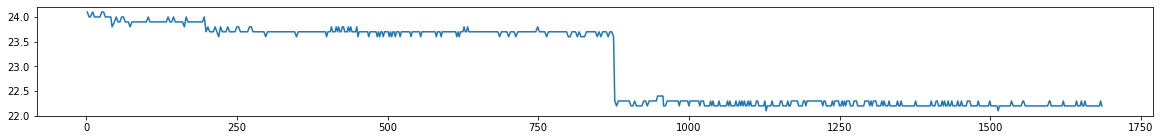

In [6]:
## Grafico de lineas sobre los valores de un sensor
pres = Resultados(selpd)
pres.grafResultados()

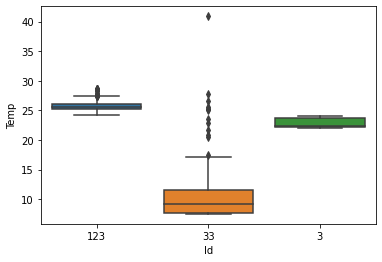

In [7]:
## Boxplots de todos las mediciones de todos los sensores
pres = Resultados(pdLista)
pres.grafBoxPlots()